**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

# 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import *
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from kneed import KneeLocator

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial as sp 

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [2]:
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


# 데이터 탐색

## Preprocessing & EDA

In [3]:
df.shape

(200, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [5]:
for i in range(len(df.columns)):
    print(df.columns[i])
    print(df[df.columns[i]].unique())
    print()

Gender
['Male' 'Female']

Age
[19 21 20 23 31 22 35 64 30 67 58 24 37 52 25 46 54 29 45 40 60 53 18 49
 42 36 65 48 50 27 33 59 47 51 69 70 63 43 68 32 26 57 38 55 34 66 39 44
 28 56 41]

Annual Income (k$)
[ 15  16  17  18  19  20  21  23  24  25  28  29  30  33  34  37  38  39
  40  42  43  44  46  47  48  49  50  54  57  58  59  60  61  62  63  64
  65  67  69  70  71  72  73  74  75  76  77  78  79  81  85  86  87  88
  93  97  98  99 101 103 113 120 126 137]

Spending Score (1-100)
[39 81  6 77 40 76 94  3 72 14 99 15 13 79 35 66 29 98 73  5 82 32 61 31
 87  4 92 17 26 75 36 28 65 55 47 42 52 60 54 45 41 50 46 51 56 59 48 49
 53 44 57 58 43 91 95 11  9 34 71 88  7 10 93 12 97 74 22 90 20 16 89  1
 78 83 27 63 86 69 24 68 85 23  8 18]



* 주어진 데이터셋은 4개의 Column으로 이루어진 고객 200명의 신상 데이터이다.
* `df.info()`를 통해 결측치가 없음을 확인하였다.
* 4개의 Feature 중 `Gender`은 Categorical, `Age`, `Annual Income (k$)`, `Spending Score (1-100)`은 Numerical이다. 
    * `Gender`에 대해 One-Hot-Encoding을 진행한 DataFrame을 선언해두도록 하자. (`data`)

In [6]:
# Gender에 대한 One-Hot-Encoding

encoder = OneHotEncoder().fit(df[['Gender']])     # One-Hot-Encoding
encoder.get_feature_names(['Gender'])

array(['Gender_Female', 'Gender_Male'], dtype=object)

In [7]:
endcoded_data = pd.DataFrame(encoder.transform(df[['Gender']]).toarray(), index = df.index,
                             columns = encoder.get_feature_names(['Gender'])) 

data = pd.concat([df, endcoded_data], sort = False, axis = 1).drop(['Gender'], axis = 1)
data     # One-Hot-Encoding 완료한 DataFrame

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0.0,1.0
2,21,15,81,0.0,1.0
3,20,16,6,1.0,0.0
4,23,16,77,1.0,0.0
5,31,17,40,1.0,0.0
...,...,...,...,...,...
196,35,120,79,1.0,0.0
197,45,126,28,1.0,0.0
198,32,126,74,0.0,1.0


* 이제 Column별 데이터 분포 및 전체적인 관계를 확인해보자.

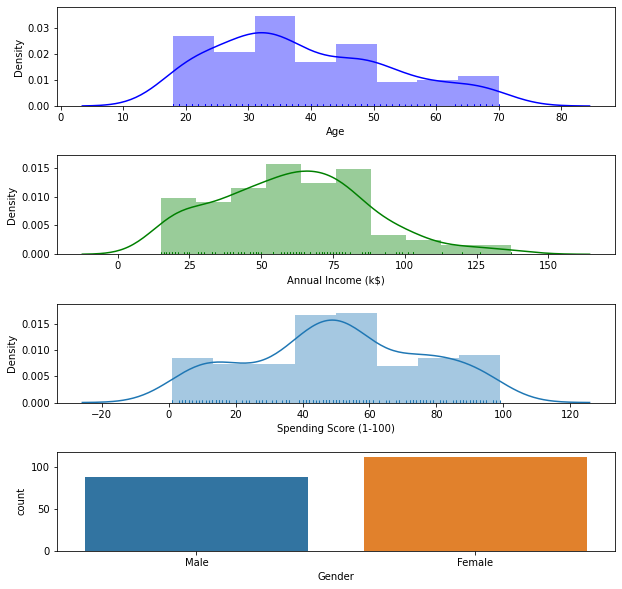

In [8]:
# Age, Annual Income (k$), Spending Score (1-100), Gender 분포

fig, ax = plt.subplots(nrows = 4, figsize=(10, 10))
plt.subplots_adjust(hspace = 0.5)
sns.distplot(data['Age'], kde = True, rug = True, ax = ax[0], color = "blue")
sns.distplot(data['Annual Income (k$)'], kde = True, rug = True, ax = ax[1], color = "green")
sns.distplot(data['Spending Score (1-100)'], kde = True, rug = True, ax = ax[2])
sns.countplot(df['Gender'], ax = ax[3])
plt.show()

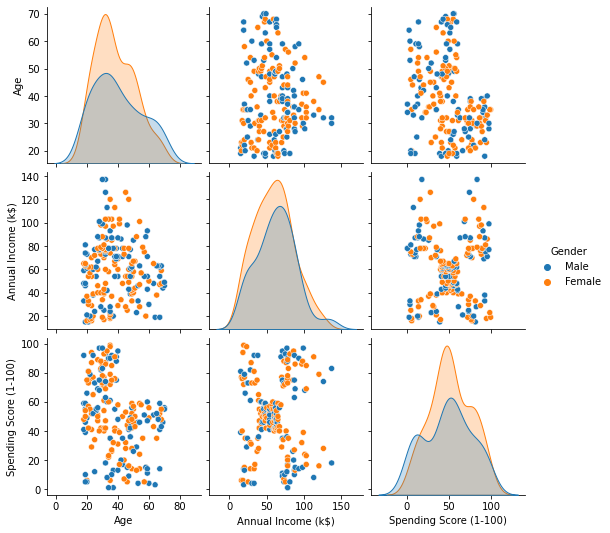

In [9]:
# Feature 간 관계 파악

sns.pairplot(df, hue = "Gender")
plt.show()

* `sns.pairplot(df, hue = "Gender")`의 결과를 보면,
* `Annual Income (k$)`(연 소득)과 `Spending Score (1-100)`(소비 점수)의 조합은 비교적 뚜렷하게 4개 or 5개의 군집으로 나눌 수 있을 것으로 예상된다.
* 4개의 군집으로 나누는 경우
    * (1) 연 소득과 소비 점수가 모두 높은 군집 (High-High)
    * (2) 연 소득이 높으면서 소비 점수가 낮은 군집 (High-Low)
    * (3) 연 소득이 낮으면서 소비 점수가 높은 군집 (Low-High)
    * (4) 연 소득과 소비 점수가 모두 낮은 군집 (Low-Low)
* 5개의 군집으로 나누는 경우
    * (1), (2), (3), (4) + (5) 연 소득과 소비 점수가 모두 중간 수준인 군집 (Medium-Medium)
* Level이 High, Medium, Low로 나뉘어진다면 최대 군집 수는 3*3 = 9개로 제한을 둘 수 있겠다.

# Clustering 알고리즘

## K-MEANS Clustering (K-평균 군집화)
* 주어진 데이터셋을 K개의 Cluster로 묶는 알고리즘 - 사전에 사용자가 군집 수를 지정해야 한다.
* 가장 단순하고 빠른 군집화 방법 중 하나

데이터 탐색 단계에서, `Annual Income (k$)`(연 소득)과 `Spending Score (1-100)`(소비 점수) 조합을 기준으로 전체 데이터가 4개에서 9개의 Cluster로 나뉘어지는 것이 적절할 것으로 판단하였다.

따라서, Elbow Point를 찾아 데이터 탐색 단계에서 예측한 군집 수의 범위(4개~9개) 안에 Elbow Point가 포함되는지를 먼저 확인해보고자 한다.

### `Annual Income (k$)`, `Spending Score (1-100)` 기준 Clustering

In [10]:
# data에서 Annual Income (k$), Spending Score (1-100) column만 추출

data_1 = data[['Annual Income (k$)', 'Spending Score (1-100)']]
data_1

,Annual Income (k$),Spending Score (1-100)
CustomerID,,
1,15,39
2,15,81
3,16,6
4,16,77
5,17,40
...,...,...
196,120,79
197,126,28
198,126,74


In [11]:
# data_1 스케일링

scaler = StandardScaler()
scaler.fit(data_1)
data_1 = pd.DataFrame(scaler.transform(data_1))     # 스케일링한 데이터를 다시 DataFrame으로
data_1

,0,1
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


In [12]:
# 스케일링한 데이터로 SSE 계산
# 클러스터 개수 변화에 따른 SSE 확인, Elbow Point 찾기 - SSE_graph 함수 활용해서 진행하자!

def SSE_graph(K, data):
    SSE = []
    k = 1
    while 1 <= k <= K:
        k_means = KMeans(n_clusters = k)     # 클러스터 개수가 k개인 모델 생성
        k_means.fit(data_1)
        SSE.append(k_means.inertia_)     # inertia : sum of squared distances of samples to their closest cluster center
        k += 1
     
    plt.plot(range(1, K+1), SSE, 'o')     # K값에 따른 SSE 표시
    plt.plot(range(1, K+1), SSE, '--')     # SSE값을 연결하는 직선 그리기
    plt.xlabel('K')
    plt.ylabel('SSE')
    kn = KneeLocator(range(1, K+1), SSE, curve = 'convex', direction = 'decreasing')     # Elbow Point 찾기
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles = 'dashed')     # Elbow Point를 수직선으로 표시
    return SSE

[399.99999999999994,
 269.01679374906655,
 157.70400815035939,
 108.92131661364358,
 65.56840815571681,
 55.057348270385965,
 44.86475569922555,
 37.22935522094305,
 32.360229825692045]

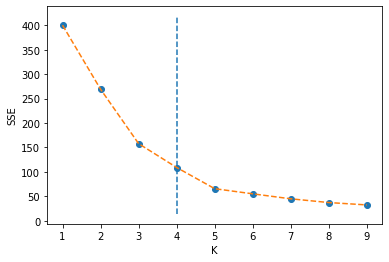

In [13]:
SSE_graph(K = 9, data = data_1)

* `SSE_graph(K = 9, data = data_1)`의 결과를 확인해보니, 초기 중심의 개수는 4개로 설정하는 것이 적절해보인다.

In [14]:
# K = 4일 때 K-Means Clustering 알고리즘 구현

k_means = KMeans(n_clusters = 4).fit(data_1)

# data에서 각 행이 어느 클러스터로 분류되었는지 확인할 수 있도록 'k=4' column 추가

data['k=4'] = k_means.labels_     # labels_ : Labels of each point

data

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4
CustomerID,,,,,,
1,19,15,39,0.0,1.0,2
2,21,15,81,0.0,1.0,1
3,20,16,6,1.0,0.0,2
4,23,16,77,1.0,0.0,1
5,31,17,40,1.0,0.0,2
...,...,...,...,...,...,...
196,35,120,79,1.0,0.0,3
197,45,126,28,1.0,0.0,0
198,32,126,74,0.0,1.0,3


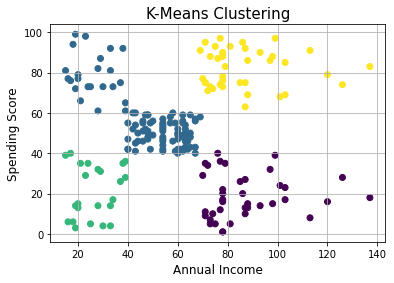

In [15]:
# K = 4일 때 K-Means Clustering의 결과를 시각화

plt.title("K-Means Clustering", fontsize=15)
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c = data['k=4'])
plt.xlabel("Annual Income", fontsize = 12)
plt.ylabel("Spending Score", fontsize = 12)
plt.grid()
plt.show()

* **Annual Income = 60, Spending Score = 40을 기준으로 총 4개의 Cluster로 분류되었으며, 각 Cluster의 특징은 아래와 같다.**
    * 왼쪽 상단 : 연 소득이 낮으면서 소비 점수가 높은 군집 (Low-High)
    * 왼쪽 하단 : 연 소득과 소비 점수가 모두 낮은 군집 (Low-Low)
    * 오른쪽 상단 : 연 소득과 소비 점수가 모두 높은 군집 (High-High)
    * 오른쪽 하단 : 연 소득이 높으면서 소비 점수가 낮은 군집 (High-Low)
    
    
* 시각화 결과를 보니, Annual Income = 40, Annual Income = 60, Spending Score = 40, Spending Score = 60을 기준으로 총 5개의 Cluster로 분류되는 것도 괜찮아 보인다. 이번에는 K = 5일 때 K-Means Clustering의 결과를 시각화해보자.

In [16]:
# K = 5일 때 K-Means Clustering 알고리즘 구현

k_means = KMeans(n_clusters = 5).fit(data_1)

data['k=5'] = k_means.labels_
data

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4,k=5
CustomerID,,,,,,,
1,19,15,39,0.0,1.0,2,2
2,21,15,81,0.0,1.0,1,0
3,20,16,6,1.0,0.0,2,2
4,23,16,77,1.0,0.0,1,0
5,31,17,40,1.0,0.0,2,2
...,...,...,...,...,...,...,...
196,35,120,79,1.0,0.0,3,4
197,45,126,28,1.0,0.0,0,3
198,32,126,74,0.0,1.0,3,4


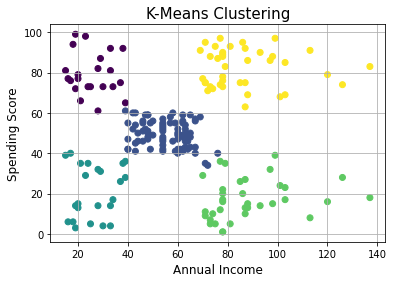

In [17]:
# K = 5일 때 K-Means Clustering의 결과를 시각화

plt.title("K-Means Clustering", fontsize=15)
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c = data['k=5'])
plt.xlabel("Annual Income", fontsize = 12)
plt.ylabel("Spending Score", fontsize = 12)
plt.grid()
plt.show()

* 시각화 결과, K = 4일 때보다 더 잘 분류되었다고 판단된다.
* **Annual Income = 40, Annual Income = 60, Spending Score = 40, Spending Score = 60을 기준으로 총 5개의 Cluster로 분류되었으며, 각 Cluster의 특징은 아래와 같다.**
    * 왼쪽 상단 : 연 소득이 낮으면서 소비 점수가 높은 군집 (Low-High)
    * 왼쪽 하단 : 연 소득과 소비 점수가 모두 낮은 군집 (Low-Low)
    * 오른쪽 상단 : 연 소득과 소비 점수가 모두 높은 군집 (High-High)
    * 오른쪽 하단 : 연 소득이 높으면서 소비 점수가 낮은 군집 (High-Low)
    * 중앙 : 연 소득과 소비 점수가 모두 중간 수준인 군집 (Medium-Medium)

### `Age`, `Spending Score (1-100)` 기준 Clustering
* `sns.pairplot(df, hue = "Gender")`의 결과에서 가장 뚜렷한 상관관계를 드러낸 Feature는 `Annual Income (k$)`과 `Spending Score (1-100)`이었지만, `Age`와 `Spending Score (1-100)`를 기준으로 Clustering을 하는 것도 유의미할 것으로 생각된다.

In [18]:
# data에서 Age, Spending Score (1-100) column만 추출

data_2 = data[['Age', 'Spending Score (1-100)']]
data_2

,Age,Spending Score (1-100)
CustomerID,,
1,19,39
2,21,81
3,20,6
4,23,77
5,31,40
...,...,...
196,35,79
197,45,28
198,32,74


In [19]:
# data_2 스케일링

scaler = StandardScaler()
scaler.fit(data_2)
data_2 = pd.DataFrame(scaler.transform(data_2))     # 스케일링한 데이터를 다시 DataFrame으로
data_2

,0,1
0,-1.424569,-0.434801
1,-1.281035,1.195704
2,-1.352802,-1.715913
3,-1.137502,1.040418
4,-0.563369,-0.395980
...,...,...
195,-0.276302,1.118061
196,0.441365,-0.861839
197,-0.491602,0.923953
198,-0.491602,-1.250054


[399.99999999999994,
 269.01679374906655,
 157.70400815035939,
 108.92131661364358,
 65.56840815571681,
 55.103778121150555,
 44.86475569922555,
 37.19454682305568,
 32.44865134833636,
 29.78724485387237]

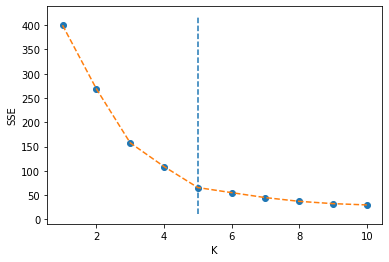

In [20]:
# 위에서 정의한 SSE_graph 함수를 활용하여 Elbow Point를 찾기
# K는 임의로 지정 (K = 10)

SSE_graph(K = 10, data = data_2)

* `SSE_graph(K = 10, data = data_2)`의 결과를 확인해보니, 초기 중심의 개수는 5개로 설정하는 것이 적절해보인다.

In [21]:
# K = 5일 때 K-Means Clustering 알고리즘 구현

k_means = KMeans(n_clusters = 5).fit(data_2)

data['k=5_2'] = k_means.labels_
data

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4,k=5,k=5_2
CustomerID,,,,,,,,
1,19,15,39,0.0,1.0,2,2,4
2,21,15,81,0.0,1.0,1,0,0
3,20,16,6,1.0,0.0,2,2,3
4,23,16,77,1.0,0.0,1,0,0
5,31,17,40,1.0,0.0,2,2,4
...,...,...,...,...,...,...,...,...
196,35,120,79,1.0,0.0,3,4,0
197,45,126,28,1.0,0.0,0,3,1
198,32,126,74,0.0,1.0,3,4,0


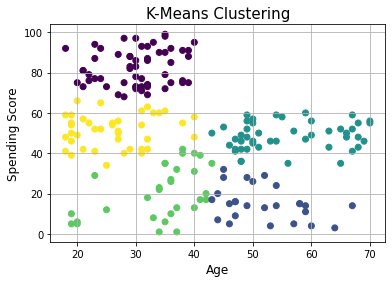

In [22]:
# K = 5일 때 K-Means Clustering의 결과를 시각화 (Age, Spending Score (1-100) 기준)

plt.title("K-Means Clustering", fontsize=15)
plt.scatter(data['Age'], data['Spending Score (1-100)'], c = data['k=5_2'])
plt.xlabel("Age", fontsize = 12)
plt.ylabel("Spending Score", fontsize = 12)
plt.grid()
plt.show()

* **Age = 40, Spending Score = 40, Spending Score = 60을 기준으로 총 5개의 Cluster로 분류되었으며, 각 Cluster의 특징은 아래와 같다.**
    * 왼쪽 상단 : 연령대가 낮으면서 소비 점수가 높은 군집 (Young-High)
    * 왼쪽 중앙 : 연령대가 낮으면서 소비 점수가 중간 수준인 군집 (Young-Medium)
    * 왼쪽 하단 : 연령대가 낮으면서 소비 점수가 낮은 군집 (Young-Low)
    * 오른쪽 중앙 : 연령대가 높으면서 소비 점수가 중간 수준인 군집 (Old-Medium)
    * 오른쪽 하단 : 연령대가 높으면서 소비 점수가 낮은 군집 (Old-Low)

* 이제 **Silhouette 통계량**을 통해 군집 결과가 타당한지 확인해보자.

In [23]:
# data 속 모든 개별 데이터에 대해 Silhouette 계수 구하기

score_samples_1 = silhouette_samples(data, data['k=4'])
score_samples_2 = silhouette_samples(data, data['k=5'])
score_samples_3 = silhouette_samples(data, data['k=5_2'])

In [24]:
# data에 Silhouette 계수 column 추가

data['silhouette_coef_k=4'] = score_samples_1
data['silhouette_coef_k=5'] = score_samples_2
data['silhouette_coef_k=5_2'] = score_samples_3

# 모든 데이터의 평균 Silhouette 계수 구하기 

average_score_1 = silhouette_score(data, data['k=4'])
average_score_2 = silhouette_score(data, data['k=5'])
average_score_3 = silhouette_score(data, data['k=5_2'])

# 결과 확인

print('K = 4일 때 평균 Silhouette 계수: {0:.3f}'.format(average_score_1))
print('K = 5일 때 평균 Silhouette 계수: {0:.3f}'.format(average_score_2))     # Annual Income, Spending Score
print('K = 5_2일 때 평균 Silhouette 계수: {0:.3f}'.format(average_score_3))     # Age, Spending Score

K = 4일 때 평균 Silhouette 계수: 0.393
K = 5일 때 평균 Silhouette 계수: 0.446
K = 5_2일 때 평균 Silhouette 계수: 0.220


In [25]:
# 군집별 평균 Silhouette 계수 구하기

print(data.groupby('k=4')['silhouette_coef_k=4'].mean())
print()
print(data.groupby('k=5')['silhouette_coef_k=5'].mean())
print()
print(data.groupby('k=5_2')['silhouette_coef_k=5_2'].mean())

k=4
0    0.475365
1    0.281112
2    0.466200
3    0.555516
Name: silhouette_coef_k=4, dtype: float64

k=5
0    0.622421
1    0.364774
2    0.418073
3    0.441116
4    0.535339
Name: silhouette_coef_k=5, dtype: float64

k=5_2
0    0.146336
1    0.012224
2    0.461441
3   -0.013659
4    0.350277
Name: silhouette_coef_k=5_2, dtype: float64


* 데이터 탐색 단계에서 판단한 바와 같이, `Annual Income (k$)`과 `Spending Score (1-100)`을 기준으로 Clustering을 진행했을 때 상대적으로 타당한 군집 결과를 얻게 됨을 알 수 있다(Silhouette 계수가 높기 때문).
* 따라서, 이어질 Hierarchical Clustering에서도 `Annual Income (k$)`과 `Spending Score (1-100)`을 기준으로 Clustering을 진행하고자 한다.

## Hierarchical Clustering (계층적 군집화)
* 여러 개의 군집 중에서 가장 유사도가 높은 군집 두 개를 선택하여 하나로 합치면서 군집 개수를 줄여 가는 방법
    * 최초에는 데이터 개수만큼 군집이 존재하지만, 군집을 합치면서 최종적으로 하나의 군집만 남게 된다.
    * 출처 : 계층적 군집화 - 데이터 사이언스 스쿨 (https://datascienceschool.net/intro.html)
    
* Hierarchical Clustering은 K-Means Clustering과 달리 사전에 군집 수를 정하지 않아도 된다는 특성을 지닌다.

In [26]:
# Clustering을 진행할 DataFrame 확인
# data에서 Annual Income (k$), Spending Score (1-100) column만 추출한 후, 스케일링 진행한 결과

data_1

,0,1
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


### scipy 패키지를 이용하는 경우

* `scipy.cluster.hierarchy.linkage` : Perform hierarchical/agglomerative clustering
    * 출처 : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
* 군집화 결과를 트리 형태로 시각화해주는 dendrogram 명령 지원
* 군집 간 거리 측정 기준 : Ward's Method

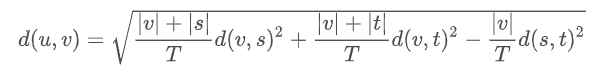

In [27]:
Z_1 = linkage(data_1, method = 'ward')

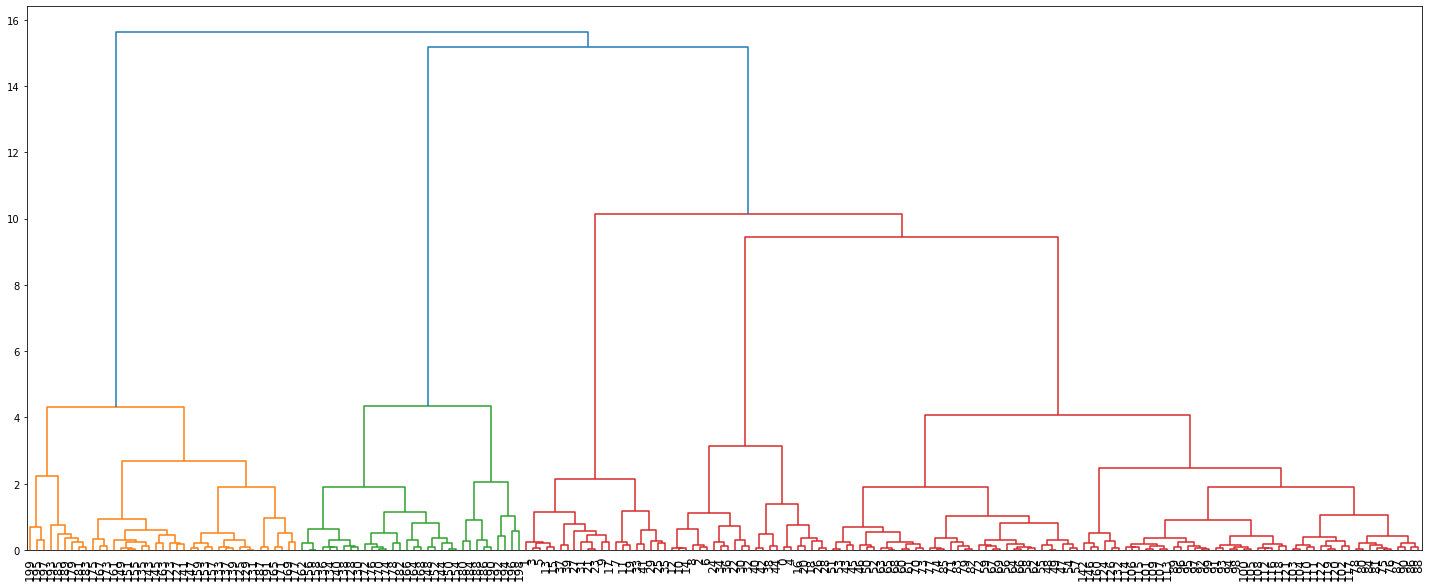

In [28]:
plt.figure(figsize = (25, 10))
dendrogram(Z_1, leaf_font_size = 12, leaf_rotation = 90)
plt.show()

* 최초 200개의 데이터에서 시작하여, 위로 올라갈수록 군집이 병합되는 구조를 `dendrogram(Z_1, leaf_font_size = 12, leaf_rotation = 90)` 시각화 결과에서 확인할 수 있다.

### scikit-learn 패키지를 이용하는 경우

* 이제는 `sklearn` 패키지를 이용해서 **병합 군집 알고리즘**을 구현해보자.
* **병합 군집 알고리즘** : 각 포인트를 하나의 클러스터로 지정하고, 어떤 종료 조건을 만족할 때까지 가장 비슷한 두 클러스터를 계속 병합


* `sklearn.cluster.AgglomerativeClustering` : Recursively merges the pair of clusters that minimally increases a given linkage distance 
    * 참고 : The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. 
    * 출처 1 : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    * 출처 2 : https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

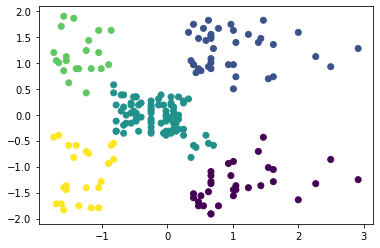

In [29]:
# (1) linkage criterion(군집 간 거리 측정 기준) = ward (minimizes the variance of the clusters being merged)
# 클러스터 개수는 가장 군집이 뚜렷하게 구분되었던 5개로 설정

agg_ward = AgglomerativeClustering(n_clusters = 5)     # default : linkage = ward
cluster_pred_1 = agg_ward.fit_predict(data_1)

# 시각화

plt.scatter(data_1[0], data_1[1], c = cluster_pred_1)
plt.show()

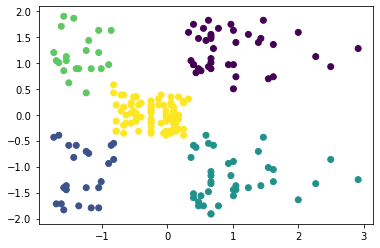

In [30]:
# (2) linkage criterion = complete (uses the maximum distances between all observations of the two sets)

agg_complete = AgglomerativeClustering(n_clusters = 5, linkage = 'complete')
cluster_pred_2 = agg_complete.fit_predict(data_1)

# 시각화

plt.scatter(data_1[0], data_1[1], c = cluster_pred_2)
plt.show()

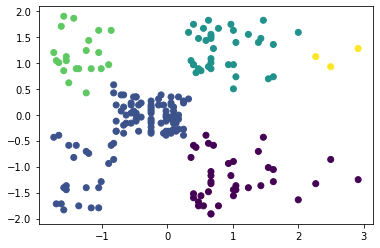

In [31]:
# (3) linkage criterion = average (uses the average of the distances of each observation of the two sets)

agg_aver = AgglomerativeClustering(n_clusters = 5, linkage = 'average')
cluster_pred_3 = agg_aver.fit_predict(data_1)

# 시각화

plt.scatter(data_1[0], data_1[1], c = cluster_pred_3)
plt.show()

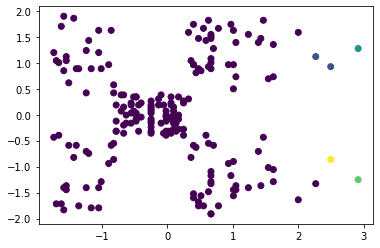

In [32]:
# (4) linkage criterion = single (uses the minimum of the distances between all observations of the two sets)

agg_single = AgglomerativeClustering(n_clusters = 5, linkage = 'single')
cluster_pred_4 = agg_single.fit_predict(data_1)

# 시각화

plt.scatter(data_1[0], data_1[1], c = cluster_pred_4)
plt.show()

* 군집 간 거리 측정 기준(Linkage Criterion) 4가지를 비교해보았다.
    * **Average**와 **Single**보다는, **Ward**와 **Complete(Maxium)**를 기준으로 Clustering을 진행한 경우 군집이 더 잘 나뉘어진 것으로 보인다.
    * 따라서, 주어진 데이터셋을 계층적으로 군집화할 때는 **Ward**나 **Complete**를 군집 간 거리 측정 기준으로 삼는 것이 타당하다고 결론 내릴 수 있겠다.
    * 참고 : https://tyami.github.io/machine%20learning/hierarchical-clustering/ 
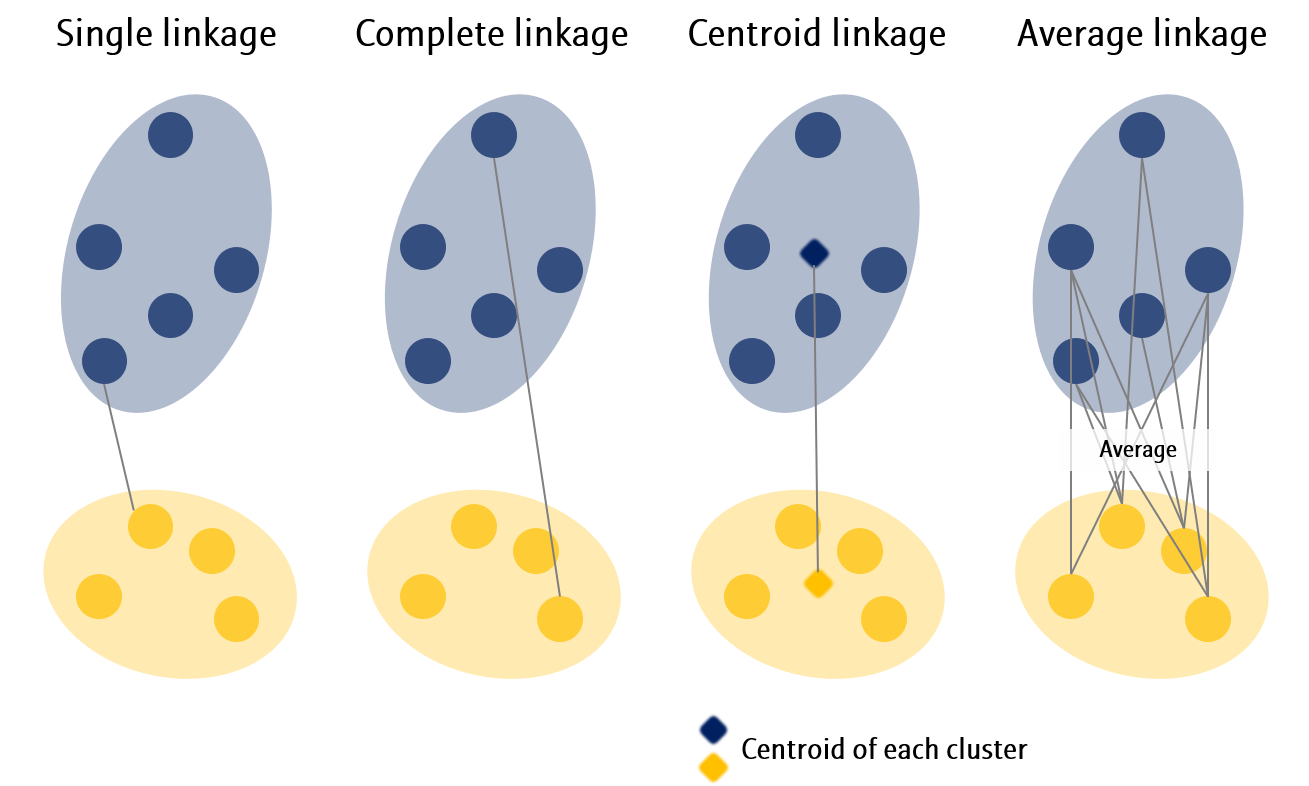

## DBSCAN Clustering
* **밀도 기반** 군집화 알고리즘 - 공간상에 높은 밀도를 가지고 모여 있는 관측치들은 하나의 그룹으로, 낮은 밀도를 가지고 떨어져 있는 관측치는 이상치나 잡음(noise)으로 분류
    * 군집의 형태에 구애받지 않으며(K-Means Clustering이 군집의 형태에 따라 군집화를 잘 수행하지 못할 수 있다는 단점을 보완), 군집의 개수를 사용자가 지정할 필요가 없다는 특징
    * 초기 데이터로부터 근접한 데이터를 찾아나가는 방법으로 군집을 확장
    * 참고 : 데이터 사이언스 스쿨, 디비스캔 군집화 (https://datascienceschool.net/intro.html) 
    
    
* `sklearn.cluster.DBSCAN` : Perform DBSCAN clustering from vector array or distance matrix.
    * DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.
    * 참고 : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [33]:
# 학습시킬 Feature 선택 - Feature이 3개인 경우

db_data = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
db_data.head()

,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40


In [34]:
# 데이터 스케일링

scaler = StandardScaler()
scaler.fit(db_data)
db_data_1 = pd.DataFrame(scaler.transform(db_data), columns = db_data.columns)     # 스케일링한 데이터를 다시 DataFrame으로
db_data_1

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [35]:
# DBSCAN 모델링

db_model_1 = DBSCAN(min_samples = 4)     # 3(학습에 사용된 feature 개수) + 1
predict = pd.DataFrame(db_model_1.fit_predict(db_data_1))
predict.columns = ['db_pred']

# 새로운 DataFrame 생성 - 기존 DataFrame과 학습 결과를 concat

db_concat_1 = pd.concat([db_data_1, predict], axis = 1)
db_concat_1

,Age,Annual Income (k$),Spending Score (1-100),db_pred
0,-1.424569,-1.738999,-0.434801,-1
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,-1
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,1
...,...,...,...,...
195,-0.276302,2.268791,1.118061,-1
196,0.441365,2.497807,-0.861839,-1
197,-0.491602,2.497807,0.923953,-1
198,-0.491602,2.917671,-1.250054,-1


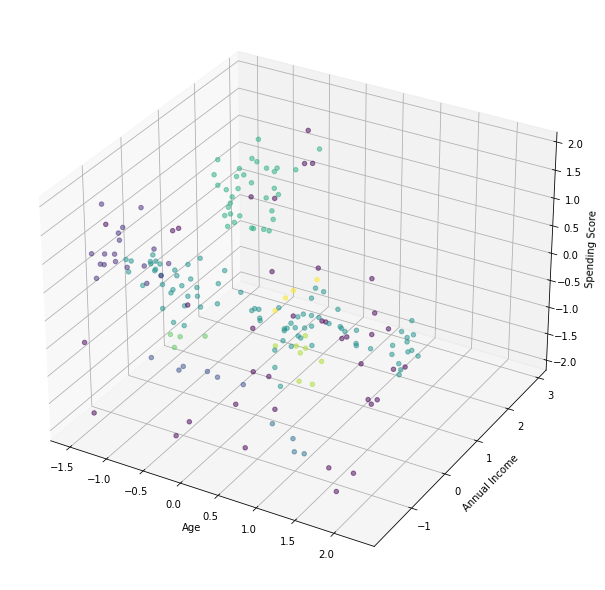

In [36]:
# 3차원 시각화

fig = plt.figure(figsize = (8, 8))
ax = Axes3D(fig)
ax.scatter(db_concat_1['Age'], db_concat_1['Annual Income (k$)'], db_concat_1['Spending Score (1-100)'],
           c = db_concat_1['db_pred'], alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
plt.show()

* 위 경우, 3개의 Feature를 동시에 고려하여 Clustering을 진행할 수 있으나 3차원 상의 Clustering 결과는 사용자 입장에서 한눈에 알아보기 어렵다.
* 이번에는 2개의 Feature만을 선별하여 학습시켜보자.

In [37]:
# 학습시킬 Feature 선택 - Feature이 2개인 경우

data_1.columns = ['Annual Income (k$)', 'Spending Score (1-100)']
data_1

,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


In [38]:
# DBSCAN 모델링

db_model_2 = DBSCAN(min_samples = 3)     # 2(학습에 사용된 feature 개수) + 1
predict_2 = pd.DataFrame(db_model_2.fit_predict(data_1))
predict_2.columns = ['db_pred']

# 새로운 DataFrame 생성 - 기존 DataFrame과 학습 결과를 concat

db_concat_2 = pd.concat([data_1, predict_2], axis = 1)
db_concat_2

,Annual Income (k$),Spending Score (1-100),db_pred
0,-1.738999,-0.434801,0
1,-1.738999,1.195704,0
2,-1.700830,-1.715913,0
3,-1.700830,1.040418,0
4,-1.662660,-0.395980,0
...,...,...,...
195,2.268791,1.118061,-1
196,2.497807,-0.861839,-1
197,2.497807,0.923953,-1
198,2.917671,-1.250054,-1


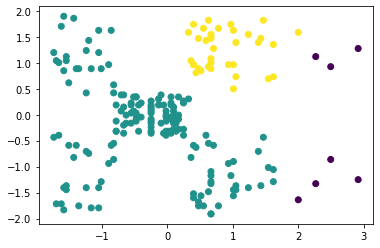

In [39]:
# 2차원 시각화

plt.scatter(db_concat_2['Annual Income (k$)'], db_concat_2['Spending Score (1-100)'], c = db_concat_2['db_pred'])
plt.show()

* 예상했던 대로 밀도가 높은 경우 하나의 그룹으로 분류하고, 동떨어져 있는 데이터들은 별도의 그룹으로 분리했다.
* 이제는 하이퍼파라미터를 조정하면서 결과가 어떻게 달라지는지 확인해보자.

In [40]:
# 하이퍼파라미터 바꾸어 보기
# 확인할 범위는 eps의 경우 0.05부터 0.7까지, min_samples의 경우 2부터 6까지로 제한
# Silhouette 계수를 높이는 최적의 eps, min_samples 찾기

db_param_options = [[0.05, 2], [0.06, 2], [0.07, 2], [0.08, 2], [0.09, 2], [0.1, 2], [0.2, 2], [0.3, 2], [0.4, 2], [0.5, 2],
                   [0.05, 3], [0.06, 3], [0.07, 3], [0.08, 3], [0.09, 3], [0.1, 3], [0.2, 3], [0.3, 3], [0.4, 3], [0.5, 3],
                   [0.06, 4], [0.07, 4], [0.08, 4], [0.09, 4], [0.1, 4], [0.2, 4], [0.3, 4], [0.4, 4], [0.5, 4], [0.6, 4],
                   [0.08, 5], [0.09, 5], [0.1, 5], [0.2, 5], [0.3, 5], [0.4, 5], [0.5, 5], [0.6, 5],
                   [0.08, 6], [0.09, 6], [0.1, 6], [0.2, 6], [0.3, 6], [0.4, 6], [0.5, 6], [0.6, 6], [0.7, 6]]
result = []

for ep, min_sample in db_param_options:
    db = DBSCAN(eps = ep, min_samples = min_sample)
    db_clusters = db.fit_predict(data_1)
    result.append([ep, min_sample, silhouette_score(data_1, db_clusters)])

In [41]:
s_score = []     # result에서 Silhouette 계수만 뽑아 저장할 리스트

for i in range(len(result)):
    s_score.append(result[i][2])

In [42]:
# Silhouette 계수가 가장 높을 때 eps, min_samples, 그리고 그때의 Silhouette 계수

max(result)

[0.7, 6, 0.4248274189039687]

* 위의 결과를 바탕으로 다시 한번 모델링을 진행하자.

In [43]:
# DBSCAN 모델링

db_model_3 = DBSCAN(eps = 0.7, min_samples = 6)
predict_3 = pd.DataFrame(db_model_3.fit_predict(data_1))
predict_3.columns = ['db_pred']

# 새로운 DataFrame 생성 - 기존 DataFrame과 학습 결과를 concat

db_concat_3 = pd.concat([data_1, predict_3], axis = 1)
db_concat_3

,Annual Income (k$),Spending Score (1-100),db_pred
0,-1.738999,-0.434801,0
1,-1.738999,1.195704,0
2,-1.700830,-1.715913,0
3,-1.700830,1.040418,0
4,-1.662660,-0.395980,0
...,...,...,...
195,2.268791,1.118061,0
196,2.497807,-0.861839,-1
197,2.497807,0.923953,-1
198,2.917671,-1.250054,-1


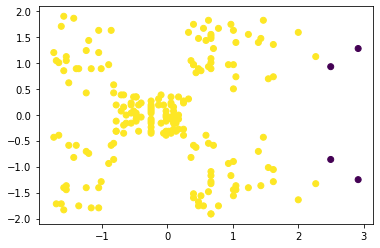

In [44]:
# 2차원 시각화

plt.scatter(db_concat_3['Annual Income (k$)'], db_concat_3['Spending Score (1-100)'], c = db_concat_3['db_pred'])
plt.show()

* 이 경우에는 Silhouette 계수는 높지만, eps가 커지면서 한 그룹에 속하는 데이터가 비교적 많아져서 유의미한 Clustering 결과로 보기에는 어렵다.

* **참고** : 데이터 스케일링을 하지 않은 경우, DBSCAN 모델링 및 시각화 결과
    * 각 Feature별로 분산이 달라 거리 측정 시 왜곡이 발생하며, Clustering이 제대로 되지 않는다.

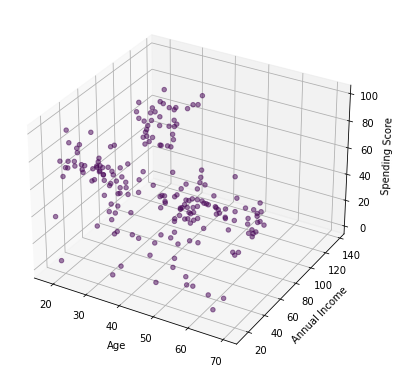

In [46]:
# 데이터 스케일링을 하지 않은 경우 DBSCAN 모델링

db_model = DBSCAN(min_samples = 4)
predict = pd.DataFrame(db_model.fit_predict(db_data))
predict.columns = ['db_pred']

# 새로운 DataFrame 생성 - 기존 DataFrame과 학습 결과를 concat

db_concat = pd.concat([db_data, predict], axis = 1)
db_concat

# 3차원 시각화

fig = plt.figure(figsize = (5, 5))
ax = Axes3D(fig)
ax.scatter(db_concat['Age'], db_concat['Annual Income (k$)'], db_concat['Spending Score (1-100)'],
           c = db_concat['db_pred'], alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
plt.show()